In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn,optim
from torch.nn import functional as F
from tqdm import tqdm
import gym


In [14]:
class PolicyNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,action_dim),nn.Softmax())
        
    def forward(self,x):
        return self.fc2(self.fc1(x))

class ValueNet(nn.Module):
    def __init__(self,state_dim,hidden_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,1))
    def forward(self,x):
        return self.fc2(self.fc1(x))
        

In [15]:
## 广义优势估计
def compute_advantage(gamma,lmbda,td_delta):
    td_delta=td_delta.detach().numpy()
    advantage_list=[]
    advantages=0
    for delta in td_delta[::-1]:
        advantages=advantages*gamma*lmbda+delta
        advantage_list.append(advantages)
    advantage_list.reverse()
    return torch.Tensor(advantage_list)

In [36]:
class PPO():
    def __init__(self,state_dim,hidden_dim,action_dim,actor_lr,critic_lr,
                lmbda,epochs,eps,gamma,device):
        self.actor=PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        self.critic=ValueNet(state_dim,hidden_dim).to(device)
        self.actor_optimizer=optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer=optim.Adam(self.critic.parameters(),lr=critic_lr)
        
        self.gamma=gamma
        self.eps=eps
        self.lmbda=lmbda
        self.epochs=epochs
        self.device=device
    def take_action(self,state):
        state=torch.Tensor(state).unsqueeze(0).to(self.device)
        prods=self.actor(state)
        action_dist=torch.distributions.Categorical(prods)
        action=action_dist.sample()
        return action.item()
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        td_target=rewards+self.gamma*self.critic(next_states)*(1-dones)
        td_delta=td_target-self.critic(states)
        advantage=compute_advantage(self.gamma,self.lmbda,td_delta.cpu()).to(self.device)
        
        old_log_probs=torch.log(self.actor(states).gather(1,actions)).detach()
        
        for epoch in range(self.epochs):
            log_probs=torch.log(self.actor(states).gather(1,actions))
            radio=torch.exp(log_probs-old_log_probs)
            surr1=radio*advantage
            surr2=torch.clamp(radio,1-self.eps,1+self.eps)*advantage
            actor_loss=torch.mean(-torch.min(surr1,surr2))
            critic_loss=torch.mean(F.mse_loss(self.critic(states),td_target.detach()))
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
        

In [38]:
actor_lr=1e-3*1.5
critic_lr=1e-2*1.5
epochs=500
hidden_dim=64
gamma=0.98
lmbda=0.92
eps=0.2
epoch=10
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

env_name='CartPole-v1'
env=gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epoch, eps, gamma, device)

return_list=[]                                                                       
for i in range(10):
    with tqdm(total=int(epochs/10),desc='iter %d'%i)as pbar:
        for j in range(epochs//10):
            epoch_return=0
            trans_dict={
                'states':[],
                'actions':[],
                'rewards':[],
                'next_states':[],
                'dones':[]
            }
            state,_=env.reset(seed=0)
            done1=False
            done2=False
            while (not done1)and (not done2):
                action=agent.take_action(state)
                next_state,reward,done1,done2,_=env.step(action)
                trans_dict['states'].append(state)
                trans_dict['actions'].append(action)
                trans_dict['rewards'].append(reward)
                trans_dict['next_states'].append(next_state)
                trans_dict['dones'].append((done1 or done2))
                state=next_state
                epoch_return+=reward
            return_list.append(epoch_return)
            agent.update(trans_dict)
            
            if (j+1)%10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+j+j),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
    
                

iter 9: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s, epoch=548, return=500.000]


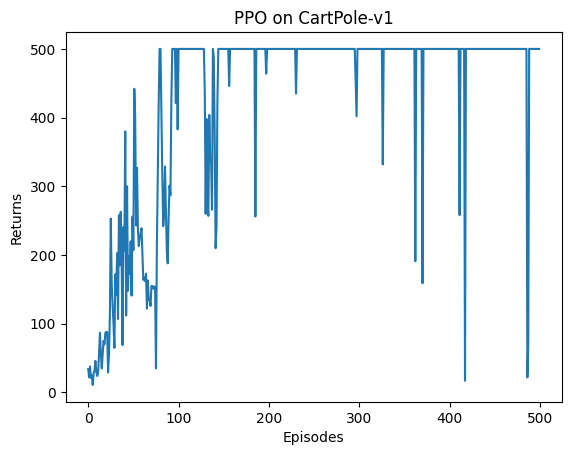

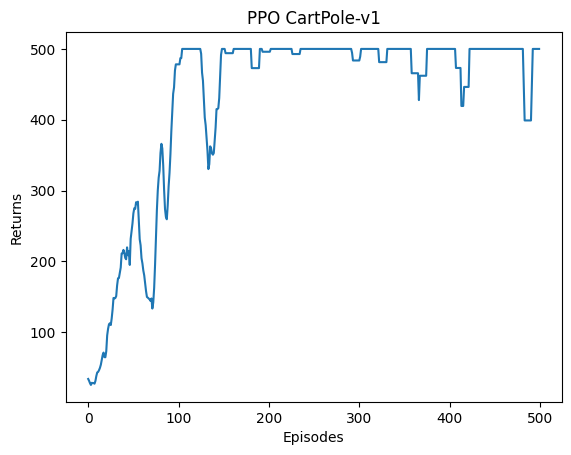

In [39]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO {}'.format(env_name))
plt.show()

In [16]:
class PolicyNetContinuous(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc_mu=nn.Sequential(nn.Linear(hidden_dim,action_dim))
        self.fc_var=nn.Sequential(nn.Linear(hidden_dim,action_dim))
    def forward(self,x):
        x=self.fc(x)
        mu=2*torch.tanh(self.fc_mu(x))
        var=F.softplus(self.fc_var(x))
        return mu,var
        

In [4]:
class PPOContinuous():
    def __init__(self,state_dim,hidden_dim,action_dim,actor_lr,critic_lr,
                lmbda,epochs,eps,gamma,device):
        self.actor=PolicyNetContinuous(state_dim,hidden_dim,action_dim).to(device)
        self.critic=ValueNet(state_dim,hidden_dim).to(device)
        self.actor_optimizer=optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer=optim.Adam(self.critic.parameters(),lr=critic_lr)
        
        self.gamma=gamma
        self.eps=eps
        self.lmbda=lmbda
        self.epochs=epochs
        self.device=device
    def take_action(self,state):
        state=torch.Tensor(state).unsqueeze(0).to(self.device)
        mu,var=self.actor(state)
        action_dist=torch.distributions.Normal(mu,var)
        action=action_dist.sample()
        return [action.item()]
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards=(rewards+8.0)/8
        td_target=rewards+self.gamma*self.critic(next_states)*(1-dones)
        td_delta=td_target-self.critic(states)
        advantage=compute_advantage(self.gamma,self.lmbda,td_delta.cpu()).to(self.device)
        
        mu,var=self.actor(states)
        action_dist=torch.distributions.Normal(mu.detach(),var.detach())
        
        old_log_probs=action_dist.log_prob(actions)
        #torch.log(self.actor(states).gather(1,actions)).detach()
        
        for epoch in range(self.epochs):
            mu,var=self.actor(states)
            action_dist=torch.distributions.Normal(mu,var)
            log_probs=action_dist.log_prob(actions)
            
            radio=torch.exp(log_probs-old_log_probs)
            surr1=radio*advantage
            surr2=torch.clamp(radio,1-self.eps,1+self.eps)*advantage
            actor_loss=torch.mean(-torch.min(surr1,surr2))
            critic_loss=torch.mean(F.mse_loss(self.critic(states),td_target.detach()))
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
        

In [10]:
actor_lr = 1e-4
critic_lr =2e-4
epochs = 2000
hidden_dim = 64
gamma = 0.9
lmbda = 0.9
epoch = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epoch, eps, gamma, device)

return_list=[]                                                                       
for i in range(10):
    with tqdm(total=int(epochs/10),desc='iter %d'%i)as pbar:
        for j in range(epochs//10):
            epoch_return=0
            trans_dict={
                'states':[],
                'actions':[],
                'rewards':[],
                'next_states':[],
                'dones':[]
            }
            state,_=env.reset(seed=0)
            done1=False
            done2=False
            while (not done1)and (not done2):
                action=agent.take_action(state)
                next_state,reward,done1,done2,_=env.step(action)
                trans_dict['states'].append(state)
                trans_dict['actions'].append(action)
                trans_dict['rewards'].append(reward)
                trans_dict['next_states'].append(next_state)
                trans_dict['dones'].append((done1 or done2))
                state=next_state
                epoch_return+=reward
            return_list.append(epoch_return)
            agent.update(trans_dict)
            
            if (j+1)%10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+j+j),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
    

iter 9: 100%|██████████| 200/200 [00:37<00:00,  5.34it/s, epoch=2198, return=-133.121]


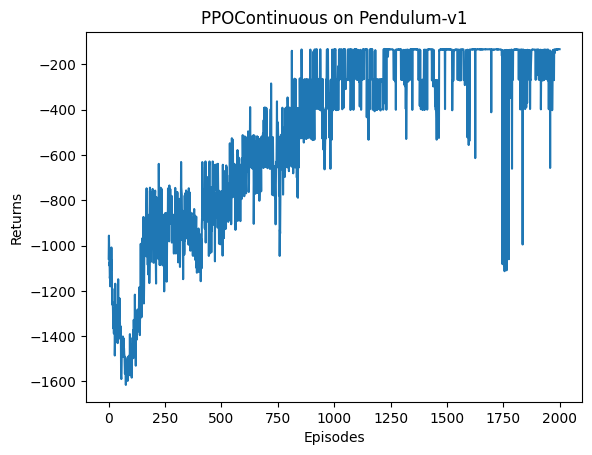

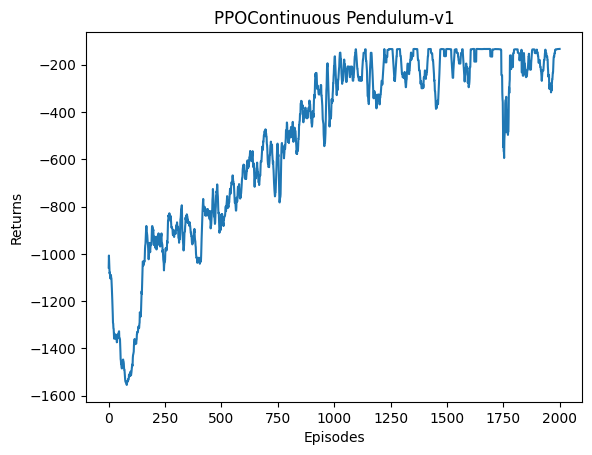

In [11]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPOContinuous on {}'.format(env_name))
plt.show()
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPOContinuous {}'.format(env_name))
plt.show()

## PPO kl-penalty

In [17]:
class PPOContinuous_kl():
    def __init__(self,state_dim,hidden_dim,action_dim,actor_lr,critic_lr,
                lmbda,epochs,beta,kl_target,gamma,device):
        self.actor=PolicyNetContinuous(state_dim,hidden_dim,action_dim).to(device)
        self.critic=ValueNet(state_dim,hidden_dim).to(device)
        self.actor_optimizer=optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer=optim.Adam(self.critic.parameters(),lr=critic_lr)
        
        self.gamma=gamma
        self.beta=beta
        self.kl_target=kl_target
        self.lmbda=lmbda
        self.epochs=epochs
        self.device=device
        self.actor_loss_list=[]
        self.critic_loss_list=[]
    def take_action(self,state):
        state=torch.Tensor(state).unsqueeze(0).to(self.device)
        mu,var=self.actor(state)
        action_dist=torch.distributions.Normal(mu,var)
        action=action_dist.sample()
        return [action.item()]
    def update(self,transition_dict):
        states = torch.tensor(np.array(transition_dict['states']),
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards=(rewards+8.0)/8
        td_target=rewards+self.gamma*self.critic(next_states)*(1-dones)
        td_delta=td_target-self.critic(states)
        advantage=compute_advantage(self.gamma,self.lmbda,td_delta.cpu()).to(self.device)
        
        mu,var=self.actor(states)
        action_dist=torch.distributions.Normal(mu.detach(),var.detach())
        
        #log_prob(self, val):返回value概率的log值
        old_log_probs=action_dist.log_prob(actions)
        old_action_probs=torch.exp(old_log_probs)
        #print(old_action_probs.shape)
        for epoch in range(self.epochs):
            #print(epoch)
            mu,var=self.actor(states)
            action_dist=torch.distributions.Normal(mu,var)
            log_probs=action_dist.log_prob(actions)
            new_action_probs=torch.exp(log_probs)
            
            #计算动作概率分布之间的KL散度
            kl=nn.KLDivLoss(reduction='mean')(F.log_softmax(old_action_probs.reshape(1,-1),dim=-1),F.softmax(new_action_probs.reshape(1,-1),dim=-1))
            
            #if(kl!=0):
            #    print(kl)
            #print(kl)
            
            radio=torch.exp(log_probs-old_log_probs)
            
            if kl>4*self.kl_target:
                break
            actor_loss=-torch.mean(radio*advantage-self.beta*kl)
            #print(actor_loss)
            critic_loss=torch.mean(F.mse_loss(self.critic(states),td_target.detach()))
            #self.actor_loss_list.append(actor_loss)
            #self.critic_loss_list.append(critic_loss)
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
        if kl<self.kl_target/1.5:
            self.beta/=2
        elif kl>self.kl_target*1.5:
            self.beta*=2
        self.beta=np.clip(self.beta,1e-4,10)
        
        

In [18]:
actor_lr = 3e-4/2
critic_lr =1e-3/1.5
epochs = 2000
hidden_dim = 64
gamma = 0.9
lmbda = 0.9
epoch =10
kl_target=0.01
beta=1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous_kl(state_dim,hidden_dim,action_dim,actor_lr,critic_lr,
                lmbda,epoch,beta,kl_target,gamma,device)

return_list=[]                                                                       
for i in range(10):
    with tqdm(total=int(epochs/10),desc='iter %d'%i)as pbar:
        for j in range(epochs//10):
            epoch_return=0
            trans_dict={
                'states':[],
                'actions':[],
                'rewards':[],
                'next_states':[],
                'dones':[]
            }
            state,_=env.reset(seed=0)
            done1=False
            done2=False
            while (not done1)and (not done2):
                action=agent.take_action(state)
                next_state,reward,done1,done2,_=env.step(action)
                trans_dict['states'].append(state)
                trans_dict['actions'].append(action)
                trans_dict['rewards'].append(reward)
                trans_dict['next_states'].append(next_state)
                trans_dict['dones'].append((done1 or done2))
                state=next_state
                epoch_return+=reward
            return_list.append(epoch_return)
            agent.update(trans_dict)
            #print(agent.beta)
            if (j+1)%10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+j+j),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
        


iter 9: 100%|██████████| 200/200 [00:38<00:00,  5.20it/s, epoch=2198, return=-135.963]


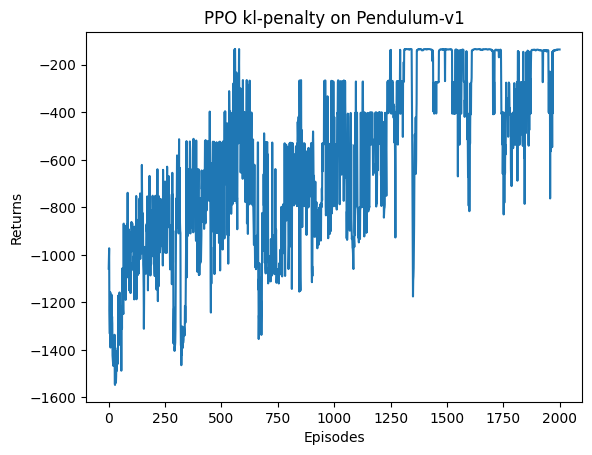

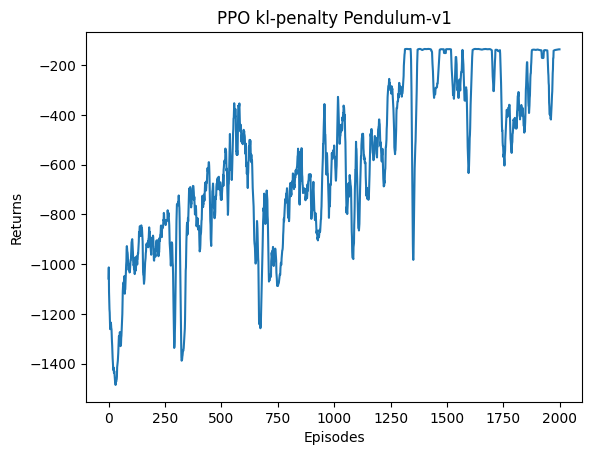

In [20]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO kl-penalty on {}'.format(env_name))
plt.show()
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO kl-penalty {}'.format(env_name))
plt.show()